In [277]:
import pandas as pd
%matplotlib inline

# Data Cleaning

In [278]:
all_complaints = pd.read_csv('data/DOB_Complaints_Received.csv')
print(list(all_complaints))
print(len(all_complaints))

['Complaint Number', 'Status', 'Date Entered', 'House Number', 'ZIP Code', 'House Street', 'BIN', 'Community Board', 'Special District', 'Complaint Category', 'Unit', 'Disposition Date', 'Disposition Code', 'Inspection Date', 'DOBRunDate']
2299448


### Handle types

In [279]:
all_complaints['Complaint Category'] = all_complaints['Complaint Category'].astype(str)

### Filter down to just Boilers

In [280]:
complaint_categories = ['56', '58', '82']
boiler_complaints = all_complaints[all_complaints['Complaint Category'].isin(complaint_categories)]

print("Number of total complaints: {}".format(len(all_complaints)))
print("Number of boiler complaints: {}".format(len(boiler_complaints)))

Number of total complaints: 2299448
Number of boiler complaints: 32310


/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


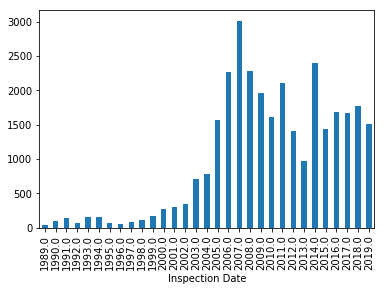

In [281]:
boiler_complaints['Inspection Date'] = pd.to_datetime(boiler_complaints['Inspection Date'])
boiler_complaints.groupby(boiler_complaints['Inspection Date'].dt.year).count()['BIN'].plot(kind='bar')

### Remove Duplicates

In [282]:
boiler_complaints = boiler_complaints.drop_duplicates(subset=['BIN', 'Date Entered'])
print("number of boiler complaints after dropping duplicates: {}".format(len(boiler_complaints)))

number of boiler complaints after dropping duplicates: 30172


### Filter down to relevant labels

I2    8779
C2    7620
A8    5343
A1    4856
H1    1075
      1039
I1     568
B1     219
C4     176
F8     108
A9      86
K1      57
C1      40
L2      34
F1      29
D6      27
G6      27
ND      21
K2      13
B2       6
G8       6
F3       6
F6       5
D2       5
Y2       4
L1       3
A3       3
Y3       2
C3       2
H2       2
A6       2
Y1       1
H5       1
F5       1
H4       1
P5       1
J1       1
J2       1
H3       1
G4       1
Name: Disposition Code, dtype: int64


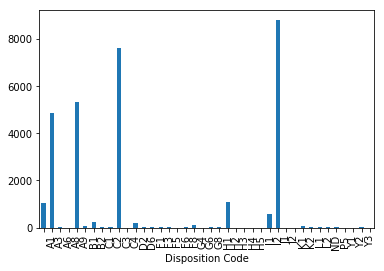

In [283]:
print(boiler_complaints['Disposition Code'].value_counts())
boiler_complaints.groupby('Disposition Code').count()['BIN'].plot('bar')

**Positive**: A8 (ECB Violation Served), A1 (Buildings Violation(s) Served), B1 (Buildings Violation(s) Prepared and Attempt to Serve will be Made)

**Negative**: I2 (No Violation Warranted for Complaint at Time of Inspection), I1 (Complaint Unsubstantiated Based on Department Records), 

**Note**: C2 (Inspector Unable to Gain Access – Final Attempt) did not include to assume we could gain access to the building.  It kind of seems like that would be a different classification task

In [284]:
positive_labels = ['A1', 'A8', 'B1']
negative_labels = ['I1', 'I2']
boiler_complaints = boiler_complaints[boiler_complaints['Disposition Code'].isin(positive_labels + negative_labels)]
print("Number of complaints after filter down to relevant dispoisition codes: {}".format(len(boiler_complaints)))

Number of complaints after filter down to relevant dispoisition codes: 19765


# Create Labels

In [285]:
labels = boiler_complaints['Disposition Code'].isin(positive_labels) * 1

In [286]:
print("Percent of labels that are positive (result in violation): {}".format(sum(labels) / len(labels)))

Percent of labels that are positive (result in violation): 0.527093346825196


# Create Features

In [287]:
features = pd.DataFrame()
features['Violation'] = labels
boiler_complaints['Violation'] = labels
features.head()

,Violation
2081,0
2082,1
2083,0
2084,1
2085,0


In [288]:
def violation_ratio_test(column):
    return features.groupby(column)['Violation'].sum() / features.groupby(column).count()['Violation']

### Boiler Category / Priority

In [289]:
boiler_complaints['Complaint Category'].value_counts()

58    17505
56     2236
82       24
Name: Complaint Category, dtype: int64

In [290]:
boiler_complaints['Complaint Category'] = boiler_complaints['Complaint Category'].astype('category')
boiler_complaints['Complaint Category'] = boiler_complaints['Complaint Category'].cat.codes
features['Complaint Category'] = boiler_complaints['Complaint Category']

In [291]:
violation_ratio_test('Complaint Category')

Complaint Category
0    0.545170
1    0.524422
2    0.791667
Name: Violation, dtype: float64

### Number of previous boiler complaints

In [292]:
def get_previous_complaints(row):
    # Get all of complaings with same BIN
    # remove complaints with same complaint number
    # get total of violation (could even do violation ratio)
    bin_complaints = boiler_complaints[boiler_complaints['BIN'] == row['BIN']]
    bin_complaints = bin_complaints[boiler_complaints['Complaint Number'] != row['Complaint Number']]
    return len(bin_complaints)

In [293]:
features['Previous Complaints'] = boiler_complaints.apply(get_previous_complaints, axis=1 )

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [294]:
features['Previous Complaints'].value_counts()

0     10145
1      3788
2      1917
3       912
4       635
5       354
6       308
7       248
9       200
8       144
14      135
10      132
40       82
73       74
69       70
13       70
11       60
52       53
12       52
16       51
22       46
19       40
37       38
18       38
15       32
26       27
25       26
24       25
23       24
20       21
17       18
Name: Previous Complaints, dtype: int64

In [295]:
violation_ratio_test('Previous Complaints')

Previous Complaints
0     0.547068
1     0.525871
2     0.555556
3     0.525219
4     0.529134
5     0.460452
6     0.561688
7     0.439516
8     0.444444
9     0.455000
10    0.409091
11    0.283333
12    0.480769
13    0.542857
14    0.407407
15    0.187500
16    0.254902
17    0.111111
18    0.394737
19    0.400000
20    0.047619
22    0.260870
23    0.916667
24    0.600000
25    0.346154
26    0.296296
37    0.236842
40    0.256098
52    0.339623
69    0.314286
73    0.243243
Name: Violation, dtype: float64

In [296]:
# The less previous complaints a building has, the more likely it is the complaint will result in a violation

In [297]:
# Checking to make sure these aren't duplicate 
boiler_complaints[boiler_complaints['BIN'] == 1015102]

,Complaint Number,Status,Date Entered,House Number,ZIP Code,House Street,BIN,Community Board,Special District,Complaint Category,Unit,Disposition Date,Disposition Code,Inspection Date,DOBRunDate,Violation
9225,1009916,CLOSED,11/23/1990,139,10001,WEST 28 STREET,1015102,105,,0,BOILR,03/24/2004,I1,2003-05-14,11/07/2018 12:00:00 AM,0
127622,1134056,CLOSED,12/19/2004,139,10001,WEST 28 STREET,1015102,105,,1,BOILR,01/24/2005,I2,2005-01-18,11/07/2018 12:00:00 AM,0
181203,1190768,CLOSED,04/10/2007,139,10001,WEST 28 STREET,1015102,105,,1,BOILR,05/04/2007,A1,2007-04-27,11/07/2018 12:00:00 AM,1


### Number of previous boiler violations
TODO: might be better for this to come from the DOB Violation dataset?

Make sure current complaint is not included in the number of previous violations! (This would include the label in the features... yikes man)

In [298]:
def get_previous_violations(row):
    # Get all of complaings with same BIN
    # remove complaints with same complaint number
    # get total of violation (could even do violation ratio)
    bin_complaints = boiler_complaints[boiler_complaints['BIN'] == row['BIN']]
    bin_complaints = bin_complaints[bin_complaints['Violation'] == 1]
    bin_complaints = bin_complaints[boiler_complaints['Complaint Number'] != row['Complaint Number']]
    return len(bin_complaints)

In [299]:
# # get_previous_violations test
# for row in boiler_complaints.iterrows():
#     num_previous_complaints = get_previous_violations(row[1])
#     print(num_previous_complaints)
# #     break

In [300]:
features['Previous Violations'] = boiler_complaints.apply(get_previous_violations, axis=1 )

/Users/apple/.virtualenvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [301]:
features['Previous Violations'].value_counts()

0     12796
1      3324
2      1478
3       729
4       373
5       240
6       173
7       121
8       118
18      114
9        97
17       54
22       50
21       44
14       21
13       14
15       10
10        9
Name: Previous Violations, dtype: int64

In [302]:
violation_ratio_test('Previous Violations')

Previous Violations
0     0.514067
1     0.549338
2     0.619080
3     0.477366
4     0.603217
5     0.600000
6     0.606936
7     0.396694
8     0.610169
9     0.309278
10    0.000000
13    1.000000
14    0.714286
15    0.000000
17    1.000000
18    0.000000
21    1.000000
22    0.000000
Name: Violation, dtype: float64

### Number of previous boiler violations / complaints ratio

In [303]:
features['Violation Ratio'] = (features['Previous Violations'] / features['Previous Complaints']).fillna(0)
features.head()

,Violation,Complaint Category,Previous Complaints,Previous Violations,Violation Ratio
2081,0,0,0,0,0.000000
2082,1,1,0,0,0.000000
2083,0,1,3,2,0.666667
2084,1,1,0,0,0.000000
2085,0,0,0,0,0.000000


In [304]:
print(features['Violation Ratio'].value_counts())
violation_ratio_test('Violation Ratio')

0.000000    12796
1.000000     3064
0.500000     1072
0.666667      434
0.333333      285
0.250000      188
0.750000      180
0.200000      127
0.428571       86
0.600000       83
0.400000       76
0.285714       68
0.800000       61
0.142857       59
0.246575       56
0.571429       52
0.833333       48
0.318841       48
0.714286       41
0.444444       39
0.075000       38
0.125000       35
0.346154       35
0.625000       30
0.375000       29
0.243243       29
0.166667       25
0.222222       25
0.050000       23
0.450000       23
            ...  
0.555556       16
0.318182       16
0.857143       15
0.684211       14
0.888889       11
0.230769       11
0.437500       10
0.320000        9
0.216216        9
0.636364        8
0.269231        8
0.363636        8
0.700000        8
0.538462        7
0.461538        7
0.416667        6
0.133333        6
0.736842        6
0.769231        4
0.727273        4
0.187500        4
0.071429        4
0.875000        4
0.153846        3
0.058824  

Violation Ratio
0.000000    0.514067
0.050000    0.130435
0.052632    1.000000
0.058824    1.000000
0.062500    1.000000
0.071429    1.000000
0.075000    0.000000
0.090909    1.000000
0.100000    1.000000
0.105263    0.000000
0.111111    0.181818
0.117647    0.000000
0.125000    0.114286
0.133333    1.000000
0.142857    0.203390
0.153846    1.000000
0.166667    0.280000
0.181818    0.444444
0.187500    1.000000
0.200000    0.173228
0.216216    1.000000
0.222222    0.360000
0.227273    0.000000
0.230769    0.000000
0.232877    1.000000
0.243243    0.000000
0.246575    0.000000
0.250000    0.292553
0.269231    1.000000
0.272727    0.550000
              ...   
0.450000    0.000000
0.461538    1.000000
0.500000    0.558769
0.538462    0.000000
0.555556    0.375000
0.571429    0.557692
0.583333    0.714286
0.600000    0.433735
0.615385    1.000000
0.625000    0.400000
0.636364    1.000000
0.642857    0.625000
0.666667    0.698157
0.684211    1.000000
0.692308    0.500000
0.700000    1.0000

# Boiler make

In [305]:
boiler_inspections = pd.read_csv('data/DOB_NOW_Boiler_Safety.csv')
list(boiler_inspections)

['Tracking Number',
 'Boiler ID',
 'Report Type',
 'ApplicantFirst Name',
 'Applicant Last Name',
 'Applicant License Type',
 'Applicant License Number',
 'Owner First Name',
 'Owner Last Name',
 'Boiler Make',
 'Boiler Model',
 'Pressure Type',
 'Inspection Type',
 'Inspection Date',
 'Defects Exist',
 'LFF (45 Days)',
 'LFF (180 Days)',
 'Filing Fee',
 'Total Amount Paid',
 'Report Status',
 'Bin Number']

### Drop nan Boiler makes

In [306]:
boiler_features = ['Boiler Make', 'Defects Exist', 'Pressure Type']

print(len(boiler_inspections))
boiler_inspections = boiler_inspections.dropna(subset=boiler_features)
print(len(boiler_inspections))

169583
162877


In [307]:
print("{} types of models".format(len(set(boiler_inspections['Boiler Model']))))
print("{} types of makes".format(len(set(boiler_inspections['Boiler Make']))))

14798 types of models
2247 types of makes


### Convert to to datetime

In [308]:
boiler_inspections['Inspection Date'] = pd.to_datetime(boiler_inspections['Inspection Date'])
boiler_inspections['Defects Exist'] = boiler_inspections['Defects Exist'].map({'Yes': 1, 'No':0})

### Clean boiler makes

In [309]:
from difflib import SequenceMatcher

def similarity(a, b):
#     print(a)
#     print(b)
#     print()
    return SequenceMatcher(None, a, b).ratio()

In [310]:
print("[similarity()] tests")
print(similarity('LOCH-CERST', 'LOCH-CREST'))
print(similarity('WEIL MCLAIN', 'BEST'))
print(similarity('H B SMITH NEW', 'SMITH    H'))
print()
# create maping of a make to the other spellings
makes = {}

for make in set(boiler_inspections['Boiler Make']):
    # is there something similar in the set of keys? if so put it in the values, if not, create a new key
#     print(f"looking at {make}")
    threshold = 0.6
    found_key = ''
    
    for key in makes.keys():
        sim = similarity(key, make)
        if sim >= threshold:
            found_key = key
            break
        else:
            continue
    
    if found_key != '':
#         print(found_key)
        makes[found_key].append(make)
    else:
        makes[make] = [make]
#     print(makes)

[similarity()] tests
0.9
0.13333333333333333
0.5217391304347826



In [311]:
print(len(makes.keys()))
# invert the mapping
inverted_makes = {}

for make_key, make_values in makes.items():
    for m in make_values:
        inverted_makes[m] = make_key
        
inverted_makes

429


{'AERCO/BMK200': 'AERCO/BMK200',
 'AERCO BMK-20L': 'AERCO/BMK200',
 'AERCO BMK-1.5': 'AERCO/BMK200',
 'AERCO BMK-2': 'AERCO/BMK200',
 'AERCO BMK 200': 'AERCO/BMK200',
 'AERO BMK  2.0LN': 'AERCO/BMK200',
 'AERCO BMK2': 'AERCO/BMK200',
 'AERCO/BENCHMARK': 'AERCO/BMK200',
 'AERCO1000': 'AERCO/BMK200',
 'AERCI BMK-3.0': 'AERCO/BMK200',
 'AERCO BMK-3.0': 'AERCO/BMK200',
 'AERCO KC': 'AERCO/BMK200',
 'AERCO BMK-30': 'AERCO/BMK200',
 'AERCO KC 1000': 'AERCO/BMK200',
 'AERCO BMK-2.0': 'AERCO/BMK200',
 'AERCO BMK-600': 'AERCO/BMK200',
 'AERCO BMK-2000': 'AERCO/BMK200',
 'AERCO BMK 3.0': 'AERCO/BMK200',
 'AERCO BMK-6.0': 'AERCO/BMK200',
 'AERCO BMK-3000': 'AERCO/BMK200',
 'AERCO KC-1000': 'AERCO/BMK200',
 'AERCO BMK': 'AERCO/BMK200',
 'ULTRA': 'ULTRA',
 'TRIAD': 'ULTRA',
 'FUTURA': 'ULTRA',
 'USRAD': 'ULTRA',
 'FUTERA': 'ULTRA',
 'DELTA': 'ULTRA',
 'TRANE': 'ULTRA',
 'UTICA': 'ULTRA',
 'H.B. SMI': 'H.B. SMI',
 'H.B. SMITH 19': 'H.B. SMI',
 'H B SMITH': 'H.B. SMI',
 'H/B SMITH': 'H.B. SMI',
 'H.B

In [312]:
# complete the mapping
boiler_inspections['Boiler Make'] = boiler_inspections['Boiler Make'].map(inverted_makes)

### Question: What are the most popular boilers?

In [313]:
top_makes = boiler_inspections.groupby('Boiler Make').count().sort_values(by='Bin Number', ascending=False)['Tracking Number'].head()
top_makes

Boiler Make
WEIL-MCLAIN      32217
GENERAL          17508
BURNHAM V905     14372
H.B. SMI         12075
ROCKMILLS BOI    11021
Name: Tracking Number, dtype: int64

### Question: Which boiler makes have the highest rate of defects?

In [314]:
boiler_make_numerator = boiler_inspections.groupby('Boiler Make').sum()['Defects Exist']

boiler_make_denominator = boiler_inspections.groupby('Boiler Make').count()['Boiler ID']

defect_make_ratio = boiler_make_numerator / boiler_make_denominator

In [315]:
# of the top 5 boilers, which are the most defective?
for make in top_makes.index:
    print("Make: {} ---- defect ratio: {}".format(make, defect_make_ratio[make]))
    print()

Make: WEIL-MCLAIN ---- defect ratio: 0.0747121085141385

Make: GENERAL ---- defect ratio: 0.09984007310943568

Make: BURNHAM V905 ---- defect ratio: 0.06575285276927359

Make: H.B. SMI ---- defect ratio: 0.09681159420289855

Make: ROCKMILLS BOI ---- defect ratio: 0.09173396243535069



In [316]:
boiler_inspections.groupby('Bin Number').count()['Tracking Number'].sort_values(ascending=False)

Bin Number
3071219    195
1088437    102
4112321     80
4092120     74
3347532     72
2116700     65
4539231     64
1008455     53
5009578     52
1082174     45
2005898     45
2097050     44
5147163     43
3056457     42
1089325     42
1014497     41
1080776     38
1014464     36
4004351     36
3189540     35
3014856     35
3061080     34
5113197     34
1048914     33
1070992     33
1088726     32
2051208     32
1054368     32
2117693     32
3062358     31
          ... 
2000864      1
2000865      1
2000866      1
3135868      1
2000732      1
2000731      1
3135918      1
3136011      1
2000602      1
3135956      1
3135955      1
2000606      1
3135952      1
2000610      1
3135946      1
2000613      1
2000614      1
2000643      1
2000704      1
2000656      1
3135917      1
2000669      1
2000672      1
3135912      1
3135908      1
3135905      1
2000684      1
3135902      1
2000690      1
3037511      1
Name: Tracking Number, Length: 70531, dtype: int64

### Bin to boiler features

In [317]:
def bin_to_boiler(bn):
    """ Returns the most recent boiler information for a given Bin.  None if no records."""
    return boiler_inspections[boiler_inspections['Bin Number'] == bn].sort_values(by='Inspection Date', ascending=False).head(1)

In [318]:
bin_to_boiler(3071219)

,Tracking Number,Boiler ID,Report Type,ApplicantFirst Name,Applicant Last Name,Applicant License Type,Applicant License Number,Owner First Name,Owner Last Name,Boiler Make,...,Pressure Type,Inspection Type,Inspection Date,Defects Exist,LFF (45 Days),LFF (180 Days),Filing Fee,Total Amount Paid,Report Status,Bin Number
164033,2019-30000103737N0001-168469,30000103737N0001,Initial,CRAIG,MUELLER,BB,5029.0,LARRY,MOSKOWITZ,YORK-SHIPLEY,...,High Pressure,Internal,2019-04-09,0,0,0,30,30,Accepted,3071219


In [337]:
# TODO: change this to get all relevant boiler features
# boiler_feature_names = ['Pressure Type', 'Boiler Make']

def get_boiler_feature(feature):
    boiler_features = []
    for row in boiler_complaints.iterrows():
        boiler_info = bin_to_boiler(row[1]['BIN'])
        
        boiler_feature = boiler_info[feature].values
#         boiler_features.append(boiler_feature)
        
        if len(boiler_feature) > 0:
            boiler_features.append(boiler_feature[0])
#             print(boiler_feature[0])
    #         print(type(boiler_info))
#             break
        else:
            boiler_features.append(None)
    #         print(len(boiler_features))

#     #     index = boiler_complaints.index[boiler_complaints['BIN'] == row[1]['BIN']].values[0]

    return boiler_features

In [340]:
features['Boiler Make'] = get_boiler_feature('Boiler Make')
features['Pressure Type'] = get_boiler_feature('Pressure Type')
print(features['Boiler Make'].head())

2081          GENERAL
2082     BURNHAM V905
2083             None
2084      WEIL-MCLAIN
2085    ROCKMILLS BOI
Name: Boiler Make, dtype: object
[      Pressure Type Boiler Make
82052  Low Pressure     GENERAL,       Pressure Type   Boiler Make
79072  Low Pressure  BURNHAM V905, Empty DataFrame
Columns: [Pressure Type, Boiler Make]
Index: [],       Pressure Type  Boiler Make
80403  Low Pressure  WEIL-MCLAIN,       Pressure Type    Boiler Make
65769  Low Pressure  ROCKMILLS BOI]


In [ ]:
features_with_boiler_features = features.dropna(subset=['Boiler Make'])

print("Percent of complaints with boiler features: {}".format(len(features_with_boiler_features) / len(features)))

print("Percent of complaints with boiler features that result in a violation (balance): {}".format(features_with_boiler_features['Violation'].sum() / len(features_with_boiler_features)))

In [341]:
features = features.dropna(subset=['Boiler Make'])
features['Boiler Make'] = features['Boiler Make'].astype('category').cat.codes
features['Pressure Type'] = features['Pressure Type'].astype('category').cat.codes
features.head()

,Violation,Complaint Category,Previous Complaints,Previous Violations,Violation Ratio,Boiler Make,Pressure Type
2081,0,0,0,0,0.0,47,1
2082,1,1,0,0,0.0,21,1
2084,1,1,0,0,0.0,125,1
2085,0,0,0,0,0.0,100,1
2087,0,0,1,0,0.0,47,1


In [ ]:
# violation_ratio_test('Boiler Make').sort_values(ascending=False)

### Question: Why do some complaints not have a BIN in the inspections?
answer: idk

In [ ]:
# TODO: inspect that complaints that don't have boiler inspections... could it be the date?
boiler_complaints['Boiler Make'] = boiler_make_column
boiler_complaints_without_boiler_features = boiler_complaints[boiler_complaints['Boiler Make'].isnull()]

boiler_complaints_without_boiler_features.groupby(boiler_complaints_without_boiler_features["Date Entered"].dt.year).count()['BIN'].plot(kind='bar')

In [ ]:
boiler_complaints.groupby(boiler_complaints["Date Entered"].dt.year).count()['BIN'].plot(kind='bar')

# Model

In [342]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [343]:
list(features)

['Violation',
 'Complaint Category',
 'Previous Complaints',
 'Previous Violations',
 'Violation Ratio',
 'Boiler Make',
 'Pressure Type']

### Create Training and test splits

In [344]:
y = features['Violation']
X = features.drop(['Violation'], axis=1)

In [345]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

In [346]:
clf = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=0)
clf.fit(X_train, y_train)

print(list(features)[1:])
print(clf.feature_importances_)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

['Complaint Category', 'Previous Complaints', 'Previous Violations', 'Violation Ratio', 'Boiler Make', 'Pressure Type']
[0.04301099 0.19052807 0.13620092 0.20072553 0.41935293 0.01018156]
0.6818089636990469
0.611058537244829


### Metrics: wooo yaaay

In [347]:
# Playing with n_estimators and max_depth improves metrics

In [348]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ROC Curve

[0 1]
[[0.49964492 0.50035508]
 [0.30588393 0.69411607]
 [0.26880346 0.73119654]
 ...
 [0.10500398 0.89499602]
 [0.53839766 0.46160234]
 [0.38663236 0.61336764]]


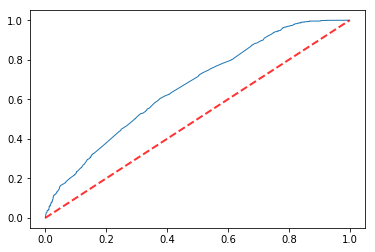

In [349]:
y_predict_probs = clf.predict_proba(X_test)
print(clf.classes_)
print(y_predict_probs)

fpr, tpr, thresholds = roc_curve(y_test, y_predict_probs[:,1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, alpha=1,
         label='ROC')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

In [350]:
# Most confident predictions
sorted(y_predict_probs[:,1])[::-1]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9961126373626373,
 0.9961126373626373,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.995,
 0.994618734923613,
 0.994618734923613,
 0.9935704948646125,
 0.9910119047619048,
 0.9908333333333335,
 0.9908333333333335,
 0.9908333333333335,
 0.990833